## Imports

In [184]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import torch
from torch.distributions import MultivariateNormal
from torch import nn

## Data Generation Function

In [183]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Gaussian Process Regressor

In [186]:
class RBFKernel(nn.Module):
    def __init__(self, length_scale=1.0, amplitude=1.0):
        super(RBFKernel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.amplitude = nn.Parameter(torch.tensor(amplitude))
        self.length_scale = nn.Parameter(torch.tensor(length_scale))
        self.lower_bound = torch.tensor([1e-6], device=self.device)
        self.upper_bound = torch.tensor([1e6], device=self.device)
    

    def forward(self, x1, x2):
        x1 = x1.unsqueeze(1)
        x2 = x2.unsqueeze(0)
        amplitude = self.amplitude.clamp(self.lower_bound, self.upper_bound)
        length_scale = self.length_scale.clamp(self.lower_bound, self.upper_bound)

        return amplitude ** 2 * torch.exp(-0.5 * (torch.linalg.norm(x1-x2, dim=2)) / length_scale ** 2)

class SinusoidalKernel(nn.Module):
    def __init__(self, amplitude=1.0, length_scale=1.0, period=1.0):
        super(SinusoidalKernel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.amplitude = nn.Parameter(torch.tensor(amplitude))
        self.length_scale = nn.Parameter(torch.tensor(length_scale))
        self.period = nn.Parameter(torch.tensor(period))
        self.lower_bound = torch.tensor([1e-6], device=self.device)
        self.upper_bound = torch.tensor([1e6], device=self.device)

    def forward(self, x1, x2):
        x1 = x1.unsqueeze(1)
        x2 = x2.unsqueeze(0)
        amplitude = self.amplitude.clamp(self.lower_bound, self.upper_bound)
        length_scale = self.length_scale.clamp(self.lower_bound, self.upper_bound)
        period = self.period.clamp(self.lower_bound, self.upper_bound)

        return amplitude ** 2 * torch.exp(-2 * torch.sin(torch.pi *torch.linalg.norm(x1 - x2, dim=2)*period)**2 / length_scale)

class GaussianProcessRegressor:
    def __init__(self, kernel, noise=0.0, max_iter=1000, restarts=0, lr=1e-3, tol=1e-6):
        self.kernel = kernel
        self.noise = noise
        self.max_iter = max_iter
        self.restarts = restarts
        self.lr = lr
        self.tol = tol
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.delta = 1e-3
    
    def fit(self, X, y):
        self.L = None
        self.X_train = X
        self.y_train = y
        self.losses = []

        for i in range(self.restarts + 1):
            optimizer = torch.optim.Adam(self.kernel.parameters(), lr=self.lr)

            for i in range(self.max_iter):
                optimizer.zero_grad()
                K = self.kernel(X, X) + (self.noise + self.delta) * torch.eye(X.shape[0], device=self.device)
                self.L = torch.linalg.cholesky(K)

                loss = self.neg_log_likelihood(self.L, y)
                if i > 0 and abs(self.losses[-1] - loss.item()) < self.tol:
                    break
                loss.backward()
                optimizer.step()
                self.losses.append(loss.item())
                if i % 100 == 0:
                    print(f'Iteration {i}, Loss: {loss.item()}')
        
        # Compute final Cholesky decomposition of the kernel matrix
        K = self.kernel(X, X) + (self.noise + self.delta) * torch.eye(X.shape[0], device=self.device)
        self.L = torch.linalg.cholesky(K)

        return self

            
    
    def neg_log_likelihood(self, L, y):
        mvnormal = MultivariateNormal(torch.zeros(y.shape[0], device=self.device), scale_tril=L)
        return -mvnormal.log_prob(y.squeeze()).sum()
    
    def predict(self, X, num_samples=None, return_std=False):
        K_test = self.kernel(X, self.X_train)
        K_inv = torch.cholesky_inverse(self.L)
        mean = K_test @ K_inv @ self.y_train

        if return_std or num_samples is not None:
            cov = self.kernel(X, X) - K_test @ K_inv @ K_test.T
            cov = cov + self.delta * torch.eye(X.shape[0], device=self.device)

        if num_samples is None:
            if return_std:
                return mean, cov.diag().sqrt()
            else:
                return mean
        else:
            mv_normal = MultivariateNormal(mean.squeeze(), covariance_matrix=cov)
            if return_std:
                return mv_normal.sample((num_samples,)), cov.diag().sqrt()
            else:
                return mv_normal.sample((num_samples,))





## Creating Gaussian Process

In [188]:
lower_in = 0
upper_in = 10
num_train = 50
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1).to(torch.device('cuda'))
y_train = f(x_train).to(torch.device('cuda'))

kernel_sin = SinusoidalKernel(amplitude=1.0, length_scale=1.0, period=0.001).to(torch.device('cuda'))
kernel_exp = RBFKernel(length_scale=1.0, amplitude=1.0).to(torch.device('cuda'))

gp_sin = GaussianProcessRegressor(kernel_sin, noise=0.0, max_iter=10_000, restarts=1, lr=0.001)
gp_sin = gp_sin.fit(x_train, y_train)

gp_exp = GaussianProcessRegressor(kernel_exp, noise=0.0, max_iter=10_000, restarts=1, lr=0.001)
gp_exp = gp_exp.fit(x_train, y_train)

Iteration 0, Loss: 24180.927734375
Iteration 100, Loss: 8126.0
Iteration 200, Loss: -51.900665283203125
Iteration 300, Loss: -127.06430053710938
Iteration 400, Loss: -153.81741333007812
Iteration 500, Loss: -167.77879333496094
Iteration 600, Loss: -176.32937622070312
Iteration 700, Loss: -182.05703735351562
Iteration 800, Loss: -186.12210083007812
Iteration 900, Loss: -189.13119506835938
Iteration 1000, Loss: -191.4314727783203
Iteration 1100, Loss: -193.22714233398438
Iteration 1200, Loss: -194.66378784179688
Iteration 1300, Loss: -195.8302459716797
Iteration 1400, Loss: -196.7865447998047
Iteration 1500, Loss: -197.5830535888672
Iteration 1600, Loss: -198.25254821777344
Iteration 1700, Loss: -198.8151397705078
Iteration 1800, Loss: -199.2911834716797
Iteration 1900, Loss: -199.69839477539062
Iteration 0, Loss: -200.03054809570312
Iteration 100, Loss: -201.99876403808594
Iteration 200, Loss: -202.08746337890625
Iteration 0, Loss: -26.33448028564453
Iteration 100, Loss: -42.76872253417

## Plotting GP Samples

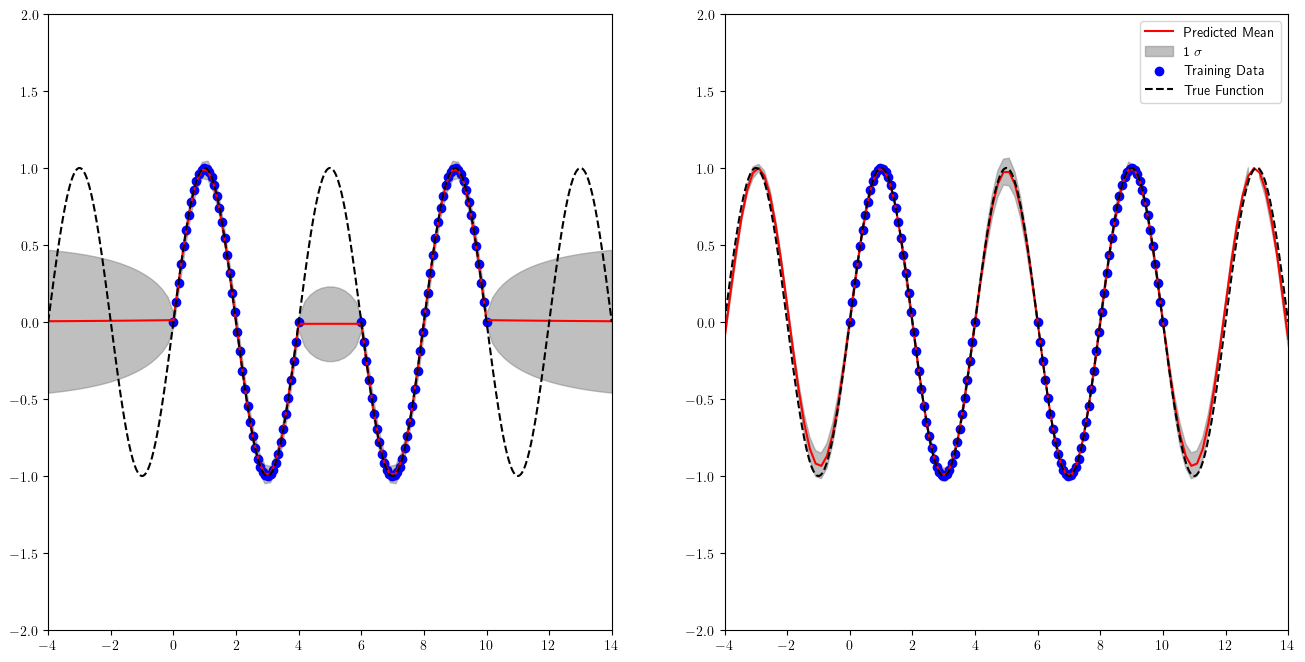

In [194]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

x_test = torch.linspace(-4, 14, 100, device=torch.device('cuda')).unsqueeze(1)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for gp, ax in zip([gp_exp, gp_sin], axs):

    y_pred, y_std = gp.predict(x_test, return_std=True)

    ax.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean')

    upper = y_pred.squeeze() + 1 * y_std
    lower = y_pred.squeeze() - 1 * y_std

    ax.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color='grey', label=r'1 $\sigma$')

    ax.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='b', marker='o', label='Training Data')

    ax.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function')

    ax.set_xlim(-4, 14)
    ax.set_ylim(-2, 2)

plt.legend()

plt.show()